In [1]:
!pip install --upgrade datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [2]:
import os
from datasets import load_dataset
import pandas as pd
import tensorflow as tf
import pandas as pd
import numpy as np
import transformers
from transformers import LongformerTokenizer
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
print(transformers.__version__)

2.18.0
4.52.4


In [3]:
dataset = load_dataset("mohammadjavadpirhadi/fake-news-detection-dataset-english", download_mode='force_redownload')
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/786 [00:00<?, ?B/s]

(…)-00000-of-00001-31aecafc15fe32e0.parquet:   0%|          | 0.00/57.0M [00:00<?, ?B/s]

(…)-00000-of-00001-1d49200ad03190fd.parquet:   0%|          | 0.00/14.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/35918 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8980 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 35918
    })
    test: Dataset({
        features: ['title', 'text', 'subject', 'date', 'label'],
        num_rows: 8980
    })
})

In [4]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Num GPUs Available: 1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16379239296429586494
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 40419328000
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8251895042841087703
physical_device_desc: "device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:00:04.0, compute capability: 8.0"
xla_global_id: 416903419
]


In [5]:
train_df = pd.DataFrame(dataset['train'][:])
test_df = pd.DataFrame(dataset['test'][:])

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35918 entries, 0 to 35917
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    35918 non-null  object
 1   text     35918 non-null  object
 2   subject  35918 non-null  object
 3   date     35918 non-null  object
 4   label    35918 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.4+ MB


In [7]:
train_df['label'].value_counts()/len(train_df) * 100

,count
label,
1,52.352581
0,47.647419


In [8]:
train_df.head()

,title,text,subject,date,label
0,"Saudi Arabia says foils Islamic State bomb, fo...",DUBAI (Reuters) - Saudi Arabia said on Tuesday...,worldnews,"September 11, 2017",0
1,GOP Just Demanded Hillary Clinton Give Them A...,"On Wednesday, the GOP in an effort to deflec...",News,"July 5, 2017",1
2,AUDIT REVEALS: 150 AFGHAN TROOPS Have Gone AWO...,The new report on the number of missing Afghan...,politics,"Oct 20, 2017",1
3,Watch Elizabeth Warren DESTROY Donald Trump i...,Senator Elizabeth Warren (D-MA) lit into Repub...,News,"March 21, 2016",1
4,Mohammed Dahlan speaks about Palestinian unity...,"GAZA (Reuters) - Mohammad Dahlan, who played a...",worldnews,"October 4, 2017",0


<Axes: xlabel='subject'>

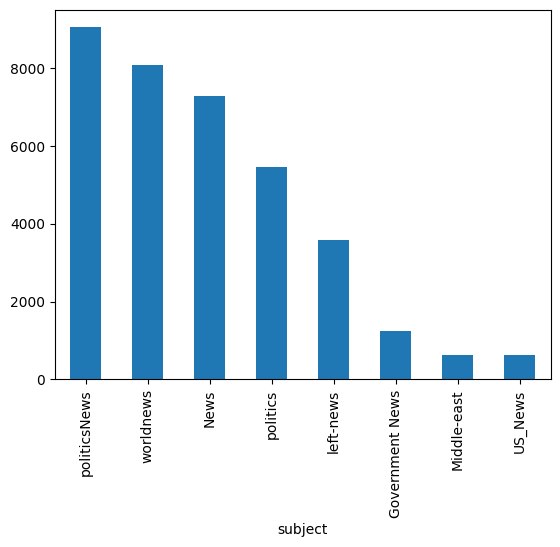

In [9]:
num_subjects = train_df['subject'].value_counts()
num_subjects.plot(kind='bar')

<Axes: xlabel='label'>

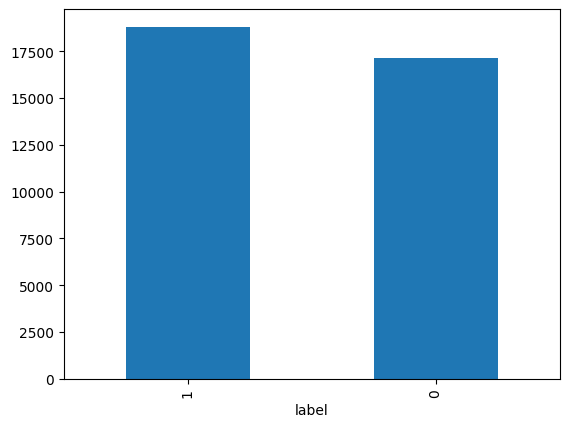

In [10]:
num_clases = train_df['label'].value_counts()
num_clases.plot(kind='bar')

In [11]:
train_df.isnull().sum()

,0
title,0
text,0
subject,0
date,0
label,0


In [12]:
train_df['subject'] = train_df['subject'].astype(str)
train_df['title'] = train_df['title'].astype(str)
train_df['text'] = train_df['text'].astype(str)
test_df['subject'] = test_df['subject'].astype(str)
test_df['title'] = test_df['title'].astype(str)
test_df['text'] = test_df['text'].astype(str)

In [13]:
train_df['full_text'] = " [TITLE] " + train_df['title'] + " [TEXT] " + train_df['text']
test_df['full_text'] = " [TITLE] " + test_df['title'] +" [TEXT] " + test_df['text']
train_df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)
test_df.drop(['title', 'text', 'subject', 'date'], axis=1, inplace=True)

In [14]:
max_len = 0
for i in range(len(train_df)):
  if len(train_df['full_text'][i]) > max_len:
    max_len = len(train_df['full_text'][i])
    id = i
print(max_len)
print(id)

51909
5242


In [15]:
train_df['full_text'][5242]

' [TITLE] MEDIA TRIPWIRE? Ping Pong Pizza Conspiracy Propels Internet Censorship Amid ‘Fake News’ Witch-Hunt [TEXT]  Funny how secrets travel. I d start to believe, if I were to bleed.    Lyrics written by David Bowie from the album OutsideShawn Helton 21st Century Wire In the days before the US presidential election in November 2016, Wikileaks revealed a new string of emails connected to Hillary Clinton s 2016 campaign chairman, John Podesta. Online interpretations of the leaked Podesta email exchanges subsequently led to a digital firestorm on social media, producing an intense conspiratorial  open source investigation  still in search of its smoking gun. However, the phenomenon now known by its hashtag #Pizzagate has since set a number of tertiary events into motion. Is there a real story hidden amongst the debris of this online explosion?Is it possible that  open source investigators  were being led into a virtual cul-de-sac and thus missing the real story?More importantly, could p

In [16]:
min_len = max_len
for i in range(len(train_df)):
  if len(train_df['full_text'][i]) < min_len:
    min_len = len(train_df['full_text'][i])
    id = i
print(min_len)
print(id)

47
26726


In [17]:
train_df['full_text'][26726]

' [TITLE] LIVE FEED: INAUGURATION 2017! [TEXT]  '

<Axes: >

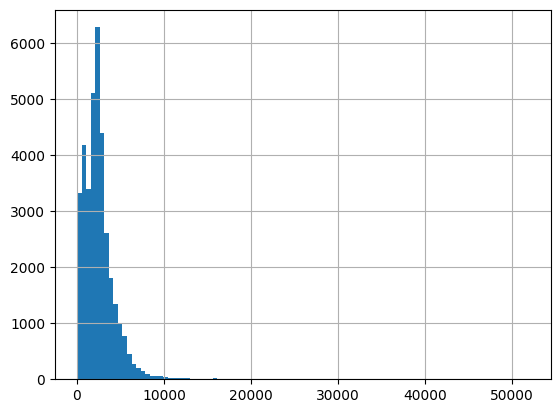

In [18]:
len_char = train_df['full_text'].apply(len)
len_char.hist(bins=100)

In [19]:
len_char.describe()

,full_text
count,35918.000000
mean,2563.422657
std,2161.731577
min,47.000000
25%,1338.250000
50%,2283.000000
75%,3194.750000
max,51909.000000


<Axes: >

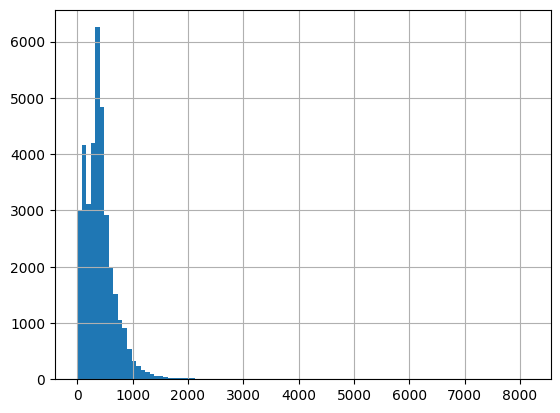

In [20]:
len_words = train_df['full_text'].apply(lambda x: len(x.split()))
len_words.hist(bins=100)

In [21]:
len_words.describe()

,full_text
count,35918.000000
mean,419.227769
std,349.390372
min,4.000000
25%,218.000000
50%,376.000000
75%,526.000000
max,8150.000000


In [22]:
num_words_more_than_75 = len_words[len_words > 800].count()
print(f'Porcentaje de registros con más de 800 palabras: {num_words_more_than_75 / len(train_df) * 100}% de {len(train_df)} registros')
num_words_less_than_25 = len_words[len_words < 70].count()
print(f'Porcentaje de registros con menos de 70 palabras: {num_words_less_than_25 / len(train_df) * 100}% de {len(train_df)} registros')

Porcentaje de registros con más de 800 palabras: 8.550030625313214% de 35918 registros
Porcentaje de registros con menos de 70 palabras: 5.532045214098781% de 35918 registros


In [23]:
train_df['full_text'].astype(str)
test_df['full_text'].astype(str)
train_df['label'].astype(int)
test_df['label'].astype(int)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35918 entries, 0 to 35917
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      35918 non-null  int64 
 1   full_text  35918 non-null  object
dtypes: int64(1), object(1)
memory usage: 561.3+ KB


In [24]:
train_texts = train_df['full_text'].tolist()
train_labels = train_df['label'].tolist()
test_texts = test_df['full_text'].tolist()
test_labels = test_df['label'].tolist()

# Hyperparameter

In [25]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 23.3 MB/s eta 0:00:00


In [28]:
import optuna
import torch
from transformers import AutoModelForSequenceClassification, DistilBertTokenizerFast
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import f1_score
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])  # Ensure text is string
        label = int(self.labels[idx]) # Ensure label is int
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def objective(trial):
    lr = trial.suggest_float("learning_rate", 1e-6, 5e-4, log=True) # Use suggest_float with log=True
    batch_size = trial.suggest_categorical("batch_size", [4, 8, 16])

    tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

    train_dataset = TextDataset(train_df['full_text'].tolist(), train_df['label'].tolist(), tokenizer)
    test_dataset = TextDataset(test_df['full_text'].tolist(), test_df['label'].tolist(), tokenizer)


    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)
    model.to(device)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(test_dataset, batch_size=8)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    model.train()
    for epoch in range(1): # Reduced epochs for faster trial
        for batch in tqdm(train_loader, leave=False):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

    model.eval()
    preds, labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            logits = model(**batch).logits
            preds += torch.argmax(logits, dim=1).cpu().tolist()
            labels += batch['labels'].cpu().tolist()

    return f1_score(labels, preds)

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=3) # Reduced trials for faster execution

df_trials = study.trials_dataframe()
df_trials.to_csv("optuna_trials.csv", index=False)

plt.plot([t.value for t in study.trials], marker='o')
plt.title("F1 Score por Trial (DistilBERT)")
plt.xlabel("Trial")
plt.ylabel("F1 Score")
plt.grid()
plt.savefig("optuna_f1_plot.png")
plt.close()

print("Mejor trial:")
print(study.best_trial)

[I 2025-06-16 05:23:53,364] A new study created in memory with name: no-name-2ca5b5ba-d164-4e85-9fd4-10c70097268d


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-16 05:31:26,062] Trial 0 finished with value: 0.999786233433091 and parameters: {'learning_rate': 3.489740263625333e-06, 'batch_size': 4}. Best is trial 0 with value: 0.999786233433091.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-06-16 05:38:20,920] Trial 1 finished with value: 0.9987187700192185 and parameters: {'lea

Mejor trial:
FrozenTrial(number=2, state=1, values=[1.0], datetime_start=datetime.datetime(2025, 6, 16, 5, 38, 20, 922066), datetime_complete=datetime.datetime(2025, 6, 16, 5, 45, 52, 550195), params={'learning_rate': 2.2660331380729098e-06, 'batch_size': 4}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'learning_rate': FloatDistribution(high=0.0005, log=True, low=1e-06, step=None), 'batch_size': CategoricalDistribution(choices=(4, 8, 16))}, trial_id=2, value=None)
